In [3]:
from __future__ import absolute_import, division, print_function

import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize

from rmexp import dbutils, schema
from rmexp.utilityfunc import app_default_utility_func

<IPython.core.display.Javascript object>


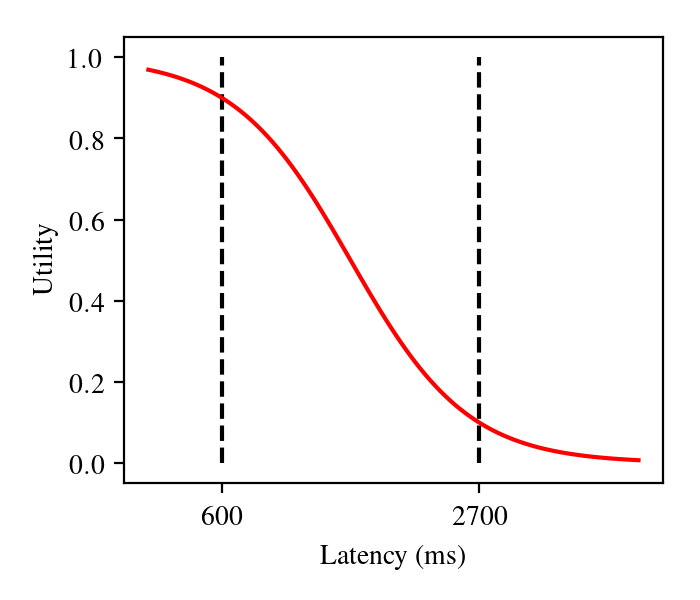

In [15]:
%matplotlib notebook

x = np.linspace(0, 4000, 100)

plt.figure(figsize=(3.5,3))
plt.plot(x, app_default_utility_func['lego'](x), 'r-')
plt.vlines([600, 2700], 0., 1., linestyles='dashed')
plt.xticks([600, 2700])
plt.xlabel('Latency (ms)')
plt.ylabel('Utility')
plt.tight_layout()
plt.savefig('fig-lat-util-%s.pdf' % 'lego', bbox_inches='tight')

In [5]:
class ResourceToLatency(object):
    def __init__(self, app):
        self.app = app
        self._df = pd.read_sql(
            'select avg(latency) as mean_latency, cpu, memory from ResourceLatency where trace like %(app)s group by trace, cpu, memory',
            schema.engine,
            params={'app': app+'%'}
        )
        
        # fit cpu
        # scipy fit is very sensitive to initial parameters
        (a, b, c, d), _ = scipy.optimize.curve_fit(lambda x,a,b,c,d: a*np.exp(d*x+b)+c, 
                                                self._df['cpu'].values, 
                                                self._df['mean_latency'].values,
                                                p0=[200, 2, 50, -2]
                                               )
        print(a,b,c,d)
        self.predict_cpu = lambda x: a*np.exp(d*x+b)+c
        
    def __call__(self, cpu, **kwargs):
        return self.predict_cpu(cpu)
        
    def print_profile(self):
        print(self._df)
        
    def plot_cpu(self, plt, memory=2, fmt='o'):
        plt.plot('cpu', 'mean_latency', fmt, data=self._df[self._df['memory']==2], label=self.app)
        

In [6]:
legop = ResourceToLatency('lego')
pingpongp = ResourceToLatency('pingpong')
poolp = ResourceToLatency('pool')
poolp.print_profile()

159.78876945 2.3526938731 112.969324963 -2.12329980683
657.504374695 -0.193646495157 31.6264004335 -1.45224465067
227.326144942 2.13587512615 44.3257277065 -2.61532828331
   mean_latency  cpu  memory
0    185.069721    1       2
1     54.591568    2       2
2     42.363702    4       2
3     48.180192    4       4
4     42.570650    8       2


/home/junjuew/work/resource-management/conda-env-rmexp/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


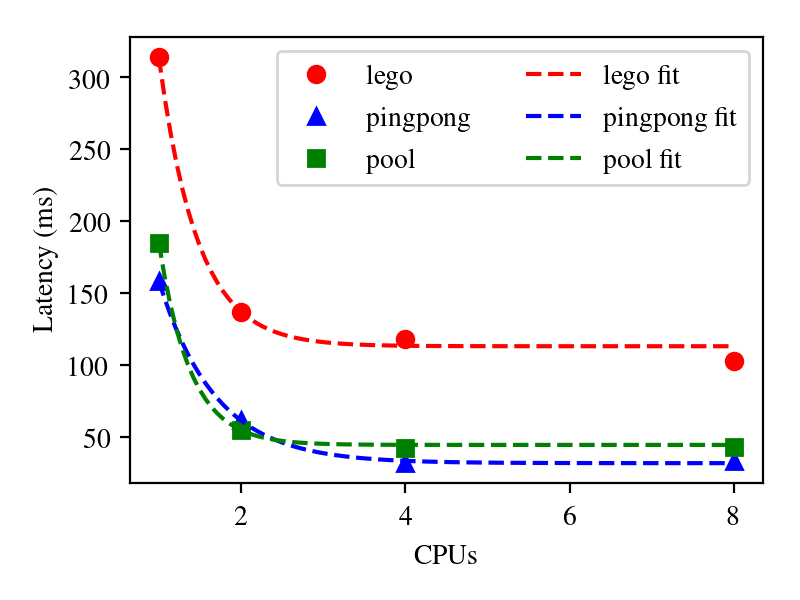

In [7]:
plt.figure(figsize=(4,3))
legop.plot_cpu(plt, fmt='ro')
pingpongp.plot_cpu(plt, fmt='b^')
poolp.plot_cpu(plt, fmt='gs')

# # fit lego
# (a, b, c, d), _ = scipy.optimize.curve_fit(lambda x,a,b,c,d: c*np.exp(-1*(x+a)) +b, legop._df['cpu'].values, legop._df['mean_latency'].values)
# print(a, b, c, d)

x = np.linspace(1, 8, 100)
plt.plot(x, legop(x), 'r--', label='lego fit')
plt.plot(x, pingpongp(x), 'b--', label='pingpong fit')
plt.plot(x, poolp(x), 'g--', label='pool fit')
plt.xlabel('CPUs')
plt.ylabel('Latency (ms)')

plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('fig-res-lat.pdf', bbox_inches='tight')

In [8]:
class ResourceToUtility(object):
    def __init__(self, res_to_lat, lat_to_util):
        self.res_to_lat = res_to_lat
        self.lat_to_util = lat_to_util
        
    def __call__(self, cpu, **kwargs):
        return self.lat_to_util(self.res_to_lat(cpu, **kwargs))

<IPython.core.display.Javascript object>


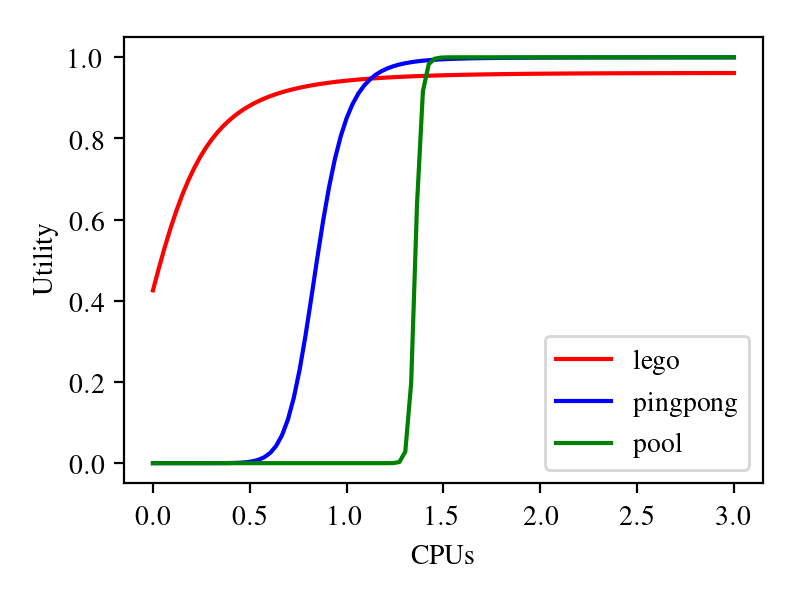

159.78876945 2.3526938731 112.969324963 -2.12329980683
657.504374695 -0.193646495157 31.6264004335 -1.45224465067
227.326144942 2.13587512615 44.3257277065 -2.61532828331


In [14]:
plt.figure(figsize=(4,3))
cpus = np.linspace(0,3,100)
for app, c in [('lego', 'r'), ('pingpong', 'b'), ('pool', 'g')]:
    uf = ResourceToUtility(ResourceToLatency(app),
                           app_default_utility_func[app])
    plt.plot(cpus, uf(cpus), c+'-', label=app)

plt.legend()
plt.xlabel("CPUs")
plt.ylabel("Utility")
plt.tight_layout()
plt.savefig('fig-res-util.pdf', bbox_inches='tight')